<a href="https://colab.research.google.com/github/nurikahraman/FoodTracker/blob/main/A_Comprehensive_Guide_to_Camera_Calibration_Using_ChArUco_Boards_and_OpenCV_for_Perspective_Projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Comprehensive Guide to Camera Calibration Using ChArUco Boards and OpenCV for Perspective Projection**

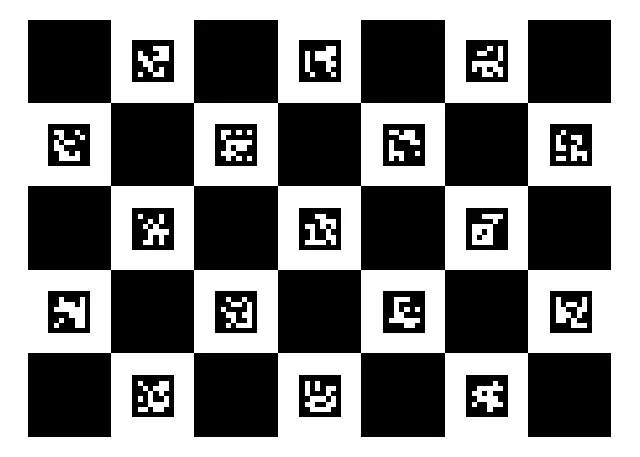

*Bilgisayarla görme ve görüntü işleme alanında, kamera kalibrasyonu, ölçümlerde ve görüntü analizinde hassasiyet ve güvenilirliğe yönelik temel bir adımdır. Bu kılavuzda, bir ChArUco kartı ve OpenCV (4.8) kullanarak bir kamerayı kalibre etme sürecini, içsel ve dışsal parametrelerin elde edilmesine ve ayrıca pikselleri gerçek dünya koordinat sistemine yansıtmak için kamera sensörü ile nesne arasındaki mesafenin hesaplanmasına odaklanarak keşfedeceğiz.*



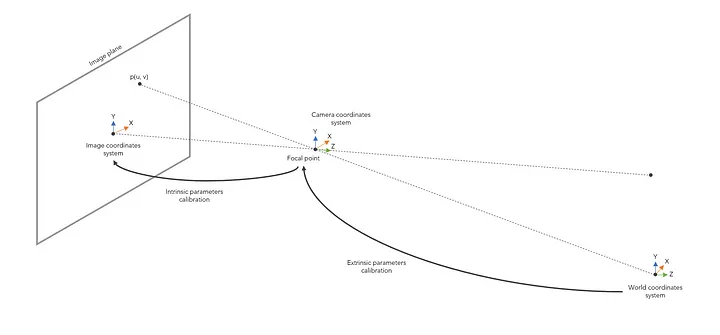

# **2. ChArUco Kurulu**

ChArUco tahtası, hem satranç tahtası hem de ArUco işaretleyicilerinin özelliklerini birleştiren hibrit bir işaretleyicidir. Yüksek hassasiyetli kalibrasyon sağlar ve sağlam poz tahmini sağlar. Başlamak için bir ChArUco kartı yazdırın ve kalibrasyon sırasında kameranın görüş alanında görünür kalmasını sağlayarak düz bir yüzeye yapıştırın.

ChArUco panomuzu yazdırmak için sabitlerimizi tanımlayarak başlayalım:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import cv2
import os

In [10]:
ARUCO_DICT = cv2.aruco.DICT_6X6_250  # Dictionary ID
SQUARES_VERTICALLY = 8               # Number of squares vertically
SQUARES_HORIZONTALLY = 12             # Number of squares horizontally
SQUARE_LENGTH = 30                   # Square side length (in pixels)
MARKER_LENGTH = 22                   # ArUco marker side length (in pixels)
MARGIN_PX = 20                       # Margins size (in pixels)

IMG_SIZE = tuple(i * SQUARE_LENGTH + 2 * MARGIN_PX for i in (SQUARES_VERTICALLY, SQUARES_HORIZONTALLY))
OUTPUT_NAME = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/OpenCv Perspective Transformation/ChArUco/ChArUco_Marker.png'

Artık parametreleri tanımladığımıza göre, ChArUco'yu bir görüntü olarak oluşturabiliriz:

In [11]:
def create_and_save_new_board():
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    size_ratio = SQUARES_HORIZONTALLY / SQUARES_VERTICALLY
    img = cv2.aruco.CharucoBoard.generateImage(board, IMG_SIZE, marginSize=MARGIN_PX)
    cv2.imwrite(OUTPUT_NAME, img)

create_and_save_new_board()

calib.io gibi bir ChArUco jeneratörü de kullanabilirsiniz.
Yazdırdıktan sonra ölçüleri kontrol ettiğinizden emin olun.

# **3. Kamera kalibrasyonu**

ChArUco kartının çeşitli açılardan ve mesafelerden birden fazla görüntüsünü yakalayın. Her görüntüde tüm panonun görünür olduğundan emin olun. Görüntüler ne kadar çeşitli olursa, kalibrasyon doğruluğu o kadar iyi olur.

Görüntüleri işlemek ve içsel ve dışsal parametreleri elde etmek için çalıştırılacak Python işlevi aşağıda verilmiştir:

In [12]:
def get_calibration_parameters(img_dir):
    # Define the aruco dictionary, charuco board and detector
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, params)

    # Load images from directory
    image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".bmp")]
    all_charuco_ids = []
    all_charuco_corners = []

    # Loop over images and extraction of corners
    for image_file in image_files:
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        imgSize = image.shape
        image_copy = image.copy()
        marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)

        if len(marker_ids) > 0: # If at least one marker is detected
            # cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
            ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)

            if charucoIds is not None and len(charucoCorners) > 3:
                all_charuco_corners.append(charucoCorners)
                all_charuco_ids.append(charucoIds)

    # Calibrate camera with extracted information
    result, mtx, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(all_charuco_corners, all_charuco_ids, board, imgSize, None, None)
    return mtx, dist

Parametreleri bir json dosyasına kaydedin:

In [15]:
SENSOR = 'monochrome'
LENS = 'kowa_f12mm_F1.8'
OUTPUT_JSON = 'calibration.json'

mtx, dist = get_calibration_parameters(img_dir='./images/')
data = {"sensor": SENSOR, "lens": LENS, "mtx": mtx.tolist(), "dist": dist.tolist()}

with open(OUTPUT_JSON, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f'Data has been saved to {OUTPUT_JSON}')

FileNotFoundError: [Errno 2] No such file or directory: './images/'

Genellikle mtx olarak gösterilen içsel matris, kameranın dahili parametrelerini temsil eder. Kameranın odak uzaklığı, optik merkezi ve çarpıklığı hakkında bilgiler içerir. İçsel matris, tipik olarak şöyle görünen 3x3'lük bir matristir:

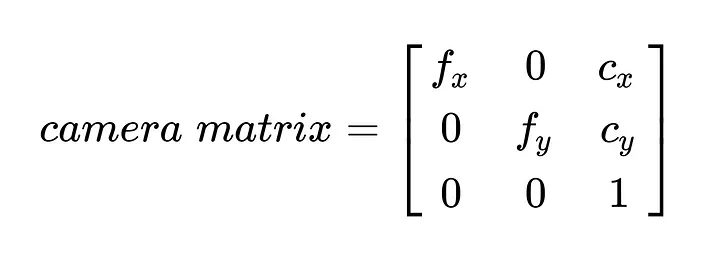

**Nerede:**



*   c_x ve c_y görüntüdeki optik merkezin piksel koordinatlarıdır.
*   f_x ve f_y sırasıyla x ve y eksenleri boyunca piksel cinsinden odak uzunluklarıdır. Odak uzaklığı, dünya koordinat sistemimiz ile görüntü koordinat sistemimiz arasındaki bir ölçek faktörünü tanımlar.

**Dist** değişkeni ile temsil edilen distorsiyon katsayıları, kameradaki lens distorsiyonunu hesaba katar. Mercek distorsiyonu, görüntülere radyal ve teğetsel distorsiyonlar getirir ve bu katsayılar bu distorsiyonların düzeltilmesine yardımcı olur. Katsayılar şu şekilde gösterilir:

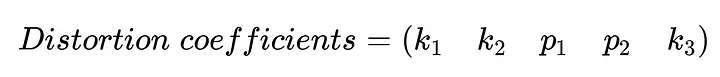

Nerede:

*   k1, k2, k3: Radyal bozulma katsayıları.
*   p1, p2: Teğetsel bozulma katsayıları.



# **4. Perspective projection**
Let’s start by retrieving our calibration parameters:

In [ ]:
json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

Artık kameramız kalibre edildiğine göre, kamera sensörü ile nesne arasındaki mesafeyi hesaplamak için ChArUco kartıyla bir görüntü yükleyebiliriz. Bozulmayı düzelterek başlayın:

In [ ]:
image_path = './charuco/charuco_WD441.bmp'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
image = cv2.undistort(image, mtx, dst, None, newcameramtx)

Şimdi Aruco'ları tespit edebilir ve konumlarını tahmin edebiliriz:

In [ ]:
all_charuco_ids = []
all_charuco_corners = []

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
if marker_ids is not None and len(marker_ids) > 0: # If at least one marker is detected
    # cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
    ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)
    if charucoCorners is not None and charucoIds is not None and len(charucoCorners) > 3:
        all_charuco_corners.append(charucoCorners)
        all_charuco_ids.append(charucoIds)

    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(np.array(all_charuco_corners)[0], np.array(all_charuco_ids)[0], board, np.array(mtx), np.array(dst), np.empty(1), np.empty(1))

    Zx, Zy, Zz = tvec[0][0], tvec[1][0], tvec[2][0]
    fx, fy = mtx[0][0], mtx[1][1]

    print(f'Zz = {Zz}\nfx = {fx}')

*   rvec ChArUco kartının 3B dönüşünü tanımlayan döndürme vektörünü temsil eden bir 1B numpy dizisidir.
*   tvec kameranın koordinat sistemindeki ChArUco kartının çevirisini tanımlayan bir 1D numpy dizisidir.

Son olarak, perspektif matrisi denklemini kullanarak görüntü çerçevesindeki bir piksel boyutunu metre cinsinden yansıtabiliriz:


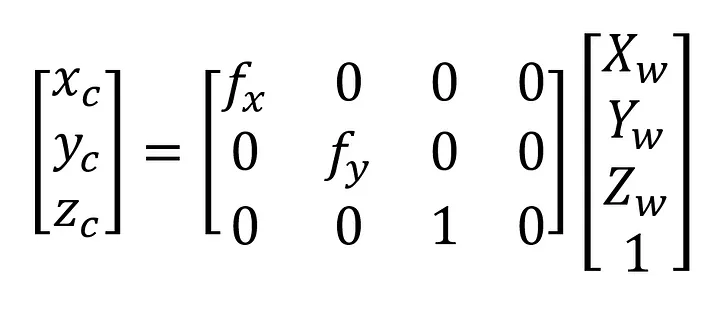

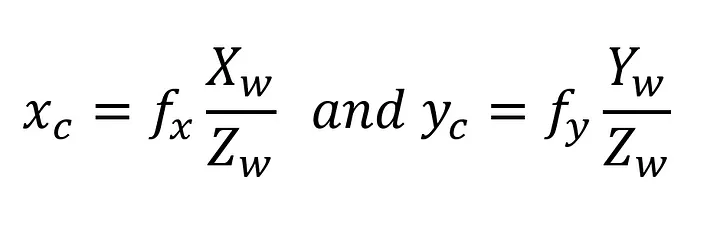

Bu denklemi tersine çevirerek, nesnelerin metre cinsinden boyutlarını piksel cinsinden boyutlarından bulabiliriz:

In [ ]:
def perspective_function(x, Z, f):
    return x*Z/f

nb_pixels = 192
print(perspective_function(nb_pixels, Zz, fx))

*Bu mesafe ölçümünün ve perspektif projeksiyonunun ChArUco kartı yerine yalnızca bir ArUco ile gerçekleştirilebileceğini unutmayın.*